# Assignment 2 - Recurrent Neural Network Dynamics 

This coursework is a study of how well a recurrent network model of primary visual cortex (V1) can represent specific features (we will use the example of orientation) of a brief visual stimulus, in the face of readout noise, depending on its connectivity.

We will begin with the experimental set up:

## Technical Set Up

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit



## Experimental Set Up

### Default Parameters

In [280]:
tau = 20 # characteristic neuron time constant (in ms)

m = 200 # number of regularly spaced orientations

n = 200 # number of neuronal inputs

B = np.eye(m,m) # feedforward input weights

C = np.eye(m,m) # matrix of output weights

sigma = 1 # noise of readout activity 

k = np.pi/4 # encoder constant

alpha = 0.9 # recurrent connection strength constant 1

alpha_prime = 0.9 # recurrent connection strength constant 2

phi = 2 * np.pi * np.linspace(0,1,m) # grid of regularly spaced parameters

dt = 1 # timestep (in ms)

### Default Functions

In [129]:
# Tuning Function
def V(z):
    return np.exp( (np.cos(z)-1) * k**(-2))


# Input Encoding Function
def h(phi, theta):
    return V(phi-theta)


# Euler Method Update Function - this is an el classico
def update_r(r_t, t, W, B, h_theta, tau, dt):
    # Dirac delta pulse at t=0
    input_term = B @ h_theta if t == 0 else 0
    
    # Correct update equation
    dr_dt = (1/tau) * (-r_t + W @ r_t + input_term)
    r = r_t + dt * dr_dt
    return r


# Noisy Readout of V1 Activity
def o_tilde_func(C, r_t, sigma):
    noise = np.random.normal(0,1, size = C.shape[0])
    return C @ r_t + sigma * noise 


# Noisy Readout data
def theta_hat_func(phi, o_tilde):

    x = np.sum(o_tilde * np.sin(phi))
    y = np.sum(o_tilde * np.cos(phi))
    
    # Return decoded orientation in [0, 2π)
    return np.arctan2(x,y)


def circ_dist(theta_hat, theta):
    # Circular distance in radians [0, π]
    return np.arccos(np.cos(theta_hat - theta))


# Rescale matrix W_raq to the spectral radius equals alpha
def R(W_raw, alpha):
    eigvals = np.linalg.eigvals(W_raw)
    spectral_radius = np.max(np.abs(eigvals))
    return (alpha / spectral_radius) * W_raw

## Simulation Function 

In [146]:
def run_simulation_rand(theta, phi, time_steps, W, B, C, tau, dt, random_seed):

    np.random.seed(random_seed)
    
    h_model = h(phi, theta)
    r_list = [np.zeros(W.shape[0])]
    
    for i, time in enumerate(time_steps[:-1]):

        r = update_r(r_list[i], time, W, B, h_model, tau, dt)
        
        r_list.append(r)
    
    return r_list[1:]  # Remove initial zero state


## Decoding Function

In [147]:
def decoding_error_func(r_list, C, sigma, phi, theta):

    decoding_error_list = []

    for r in r_list:
        
        noise = np.random.normal(0, 1, size=C.shape[0])
        o_tilde = C @ r + sigma * noise
        
        numerator = np.sum(o_tilde * np.sin(phi))
        denominator = np.sum(o_tilde * np.cos(phi))
        
        theta_hat = np.arctan2(numerator, denominator)
        decoding_error = np.arccos(np.cos(theta_hat - theta))
        decoding_error_list.append(decoding_error)
    
    return decoding_error_list

## Questions and Experiments

### Question 1 - Integrating the Dynamics of the 4 different Models

#### Model 1: No Recurrence

In [148]:
m = 200
n = 200
time_steps = np.linspace(0,60,100)
theta = np.pi
W_1 = np.zeros((m,n))
B = np.eye(m,m) # feedforward input weights
C = np.eye(m,m) # matrix of output weights

# Run the simulation
r_list_w1 = run_simulation(
    theta = np.pi, 
    phi = 2 * np.pi * np.linspace(0,1,m),
    time_steps = np.linspace(0,60,100), 
    W = W_1,
    B = np.eye(m),
    C = np.eye(m), 
    tau = 20, 
    dt = 1, 
)

# Find the decoding error
decoding_error_w1 = decoding_error_func(
    r_list = r_list_w1, 
    C = np.eye(m), 
    sigma = 1, 
    phi = 2 * np.pi * np.linspace(0,1,m), 
    theta = np.pi)


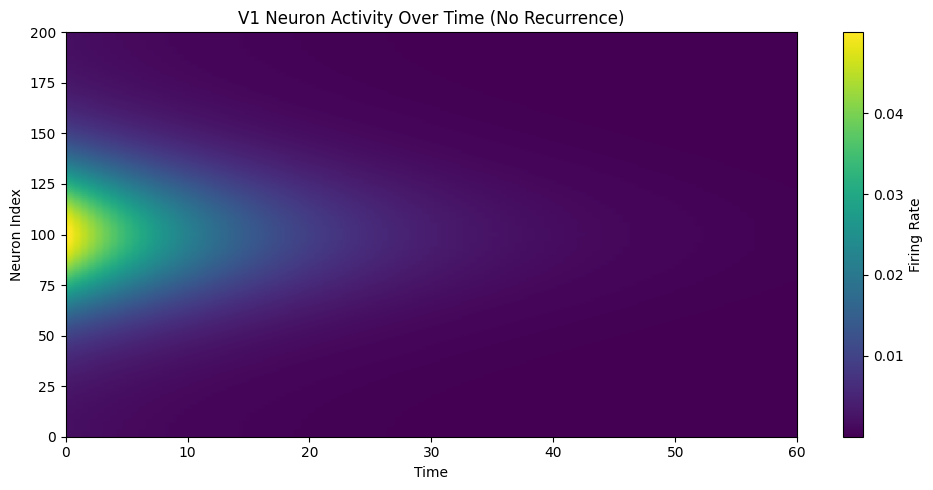

In [232]:
r_mat = np.array(r_list_w1)  # shape: (timesteps, neurons)

plt.figure(figsize=(10, 5))
plt.imshow(r_mat.T, aspect='auto', cmap='viridis', origin='lower',
           extent=[time_steps[0], time_steps[-1], 0, r_mat.shape[1]])
plt.colorbar(label='Firing Rate')
plt.xlabel('Time')
plt.ylabel('Neuron Index')
plt.title('V1 Neuron Activity Over Time (No Recurrence)')
plt.tight_layout()
plt.show()


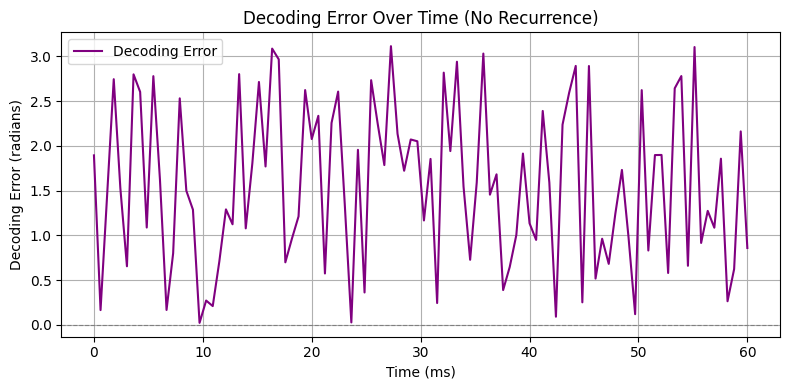

In [233]:
# Plot
plt.figure(figsize=(8, 4))
plt.plot(time_steps, decoding_error_w1, label='Decoding Error', color='purple')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.xlabel('Time (ms)')
plt.ylabel('Decoding Error (radians)')
plt.title('Decoding Error Over Time (No Recurrence)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

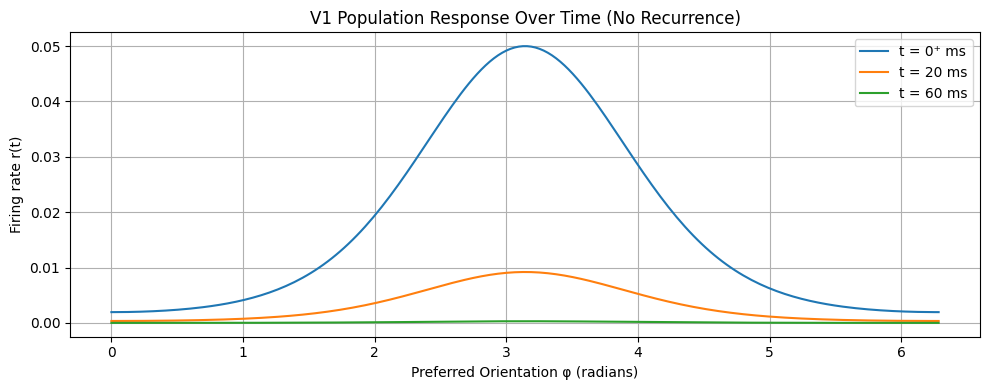

In [234]:
# Convert time steps to indices
idx_0p = 0
idx_20 = np.argmin(np.abs(time_steps - 20))
idx_60 = np.argmin(np.abs(time_steps - 60))

# Extract r(t) vectors
r_0p = r_list_w1[idx_0p]
r_20 = r_list_w1[idx_20]
r_60 = r_list_w1[idx_60]

phi = 2 * np.pi * np.linspace(0, 1, m)  # match your code

plt.figure(figsize=(10, 4))
plt.plot(phi, r_0p, label='t = 0⁺ ms')
plt.plot(phi, r_20, label='t = 20 ms')
plt.plot(phi, r_60, label='t = 60 ms')
plt.xlabel('Preferred Orientation φ (radians)')
plt.ylabel('Firing rate r(t)')
plt.title('V1 Population Response Over Time (No Recurrence)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Model 2: Random Symmetric Connectivity

In [282]:
# Model 2: Random symmetric connectivity
B = np.eye(m,m) # feedforward input weights
C = np.eye(m,m) # matrix of output weights
W_tilde = np.random.normal(0, 1, size=B.shape)
W_2 = R(W_tilde + W_tilde.T, alpha)

m = 200
n = 200
time_steps = np.linspace(0,60,100)
theta = np.pi

# Run the simulation
r_list_w2 = run_simulation(
    theta = np.pi, 
    phi = 2 * np.pi * np.linspace(0,1,m),
    time_steps = np.linspace(0,60,100), 
    W = W_2,
    B = np.eye(m),
    C = np.eye(m), 
    tau = 20, 
    dt = 1, 
)

# Find the decoding error
decoding_error_w2 = decoding_error_func(
    r_list = r_list_w2, 
    C = np.eye(m), 
    sigma = 1, 
    phi = 2 * np.pi * np.linspace(0,1,m), 
    theta = np.pi)

##### Plotting

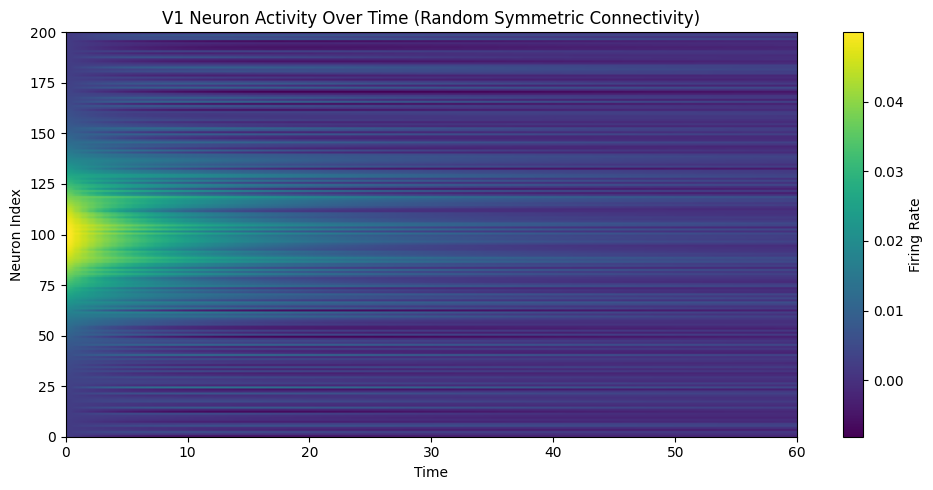

In [283]:
r_mat_w2 = np.array(r_list_w2)  # shape: (timesteps, neurons)

plt.figure(figsize=(10, 5))
plt.imshow(r_mat_w2.T, aspect='auto', cmap='viridis', origin='lower',
           extent=[time_steps[0], time_steps[-1], 0, r_mat.shape[1]])
plt.colorbar(label='Firing Rate')
plt.xlabel('Time')
plt.ylabel('Neuron Index')
plt.title('V1 Neuron Activity Over Time (Random Symmetric Connectivity)')
plt.tight_layout()
plt.show()


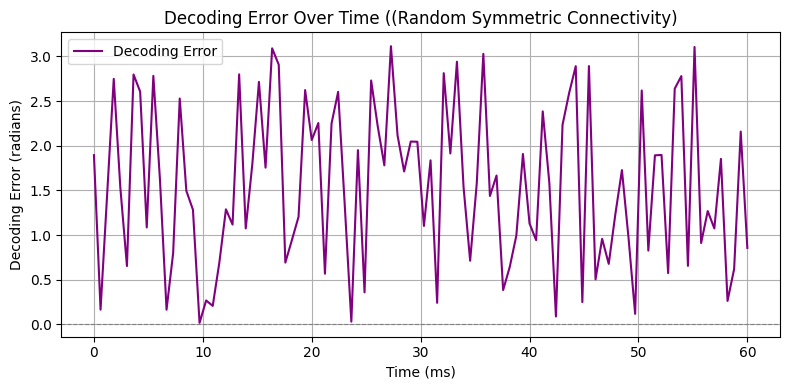

In [237]:
# Plot
plt.figure(figsize=(8, 4))
plt.plot(time_steps, decoding_error_w2, label='Decoding Error', color='purple')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.xlabel('Time (ms)')
plt.ylabel('Decoding Error (radians)')
plt.title('Decoding Error Over Time ((Random Symmetric Connectivity)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

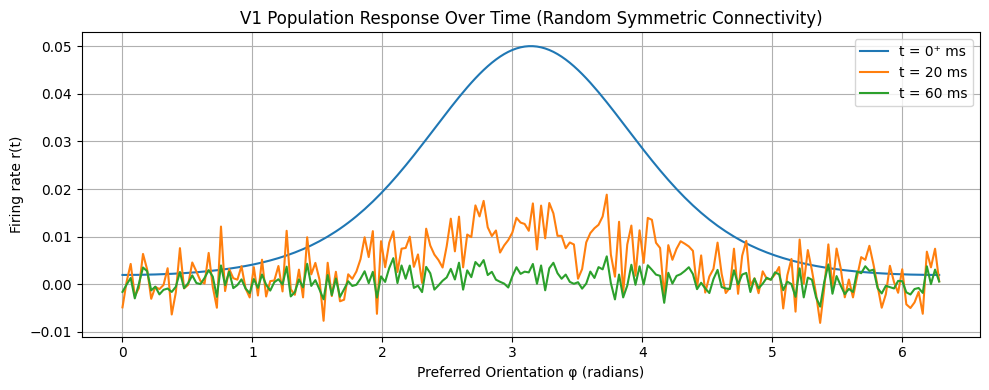

In [238]:
# Convert time steps to indices
idx_0p = 0
idx_20 = np.argmin(np.abs(time_steps - 20))
idx_60 = np.argmin(np.abs(time_steps - 60))

# Extract r(t) vectors
r_0p = r_list_w2[idx_0p]
r_20 = r_list_w2[idx_20]
r_60 = r_list_w2[idx_60]

phi = 2 * np.pi * np.linspace(0, 1, m)  # match your code

plt.figure(figsize=(10, 4))
plt.plot(phi, r_0p, label='t = 0⁺ ms')
plt.plot(phi, r_20, label='t = 20 ms')
plt.plot(phi, r_60, label='t = 60 ms')
plt.xlabel('Preferred Orientation φ (radians)')
plt.ylabel('Firing rate r(t)')
plt.title('V1 Population Response Over Time (Random Symmetric Connectivity)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [242]:
print(np.linalg.norm(np.array(r_list_w1) - np.array(r_list_w2)))
print(np.linalg.norm(np.array(decoding_error_w1) - np.array(decoding_error_w2)))


0.4960963049322935
0.14861102835407775


So the above shows that these in fact ARE changing - but just not very much! Hence, the recurrence isn't strong or directional enough. The stimulus is brief and noise masks the effect!

#### Model 3: Symmetric Ring Structure

In [243]:
W_ij = np.zeros_like(B)
for i in range(n):
    for j in range(n):
        W_ij[i,j] = V(phi[i]-phi[j])

W_3 = R(W_ij, alpha)


# Run the simulation
r_list_w3 = run_simulation(
    theta = np.pi, 
    phi = 2 * np.pi * np.linspace(0,1,m),
    time_steps = np.linspace(0,60,100), 
    W = W_3,
    B = np.eye(m),
    C = np.eye(m), 
    tau = 20, 
    dt = 1, 
)

# Find the decoding error
decoding_error_w3 = decoding_error_func(
    r_list = r_list_w3, 
    C = np.eye(m), 
    sigma = 1, 
    phi = 2 * np.pi * np.linspace(0,1,m), 
    theta = np.pi)


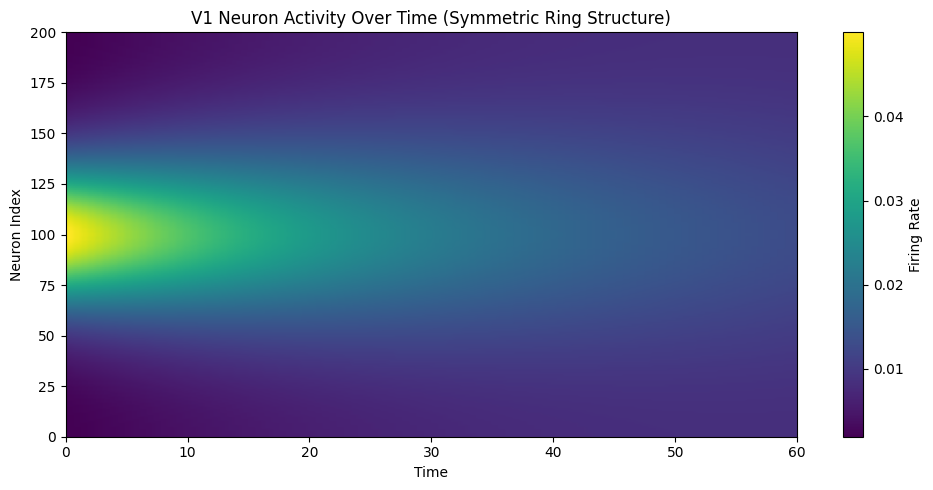

In [244]:
r_mat_w3 = np.array(r_list_w3)  # shape: (timesteps, neurons)

plt.figure(figsize=(10, 5))
plt.imshow(r_mat_w3.T, aspect='auto', cmap='viridis', origin='lower',
           extent=[time_steps[0], time_steps[-1], 0, r_mat_w3.shape[1]])
plt.colorbar(label='Firing Rate')
plt.xlabel('Time')
plt.ylabel('Neuron Index')
plt.title('V1 Neuron Activity Over Time (Symmetric Ring Structure)')
plt.tight_layout()
plt.show()


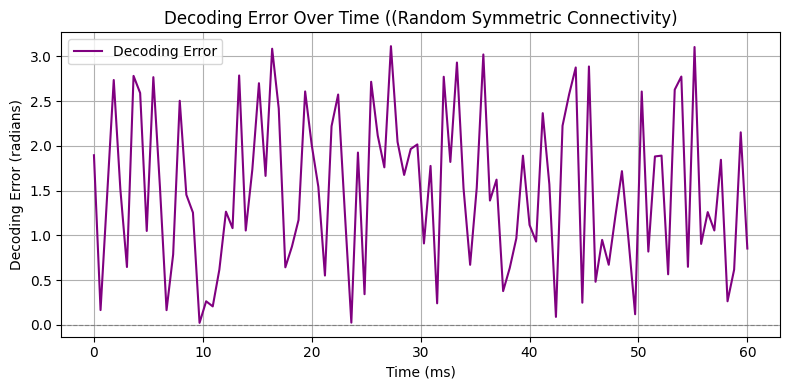

In [245]:
# Plot
plt.figure(figsize=(8, 4))
plt.plot(time_steps, decoding_error_w3, label='Decoding Error', color='purple')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.xlabel('Time (ms)')
plt.ylabel('Decoding Error (radians)')
plt.title('Decoding Error Over Time ((Random Symmetric Connectivity)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

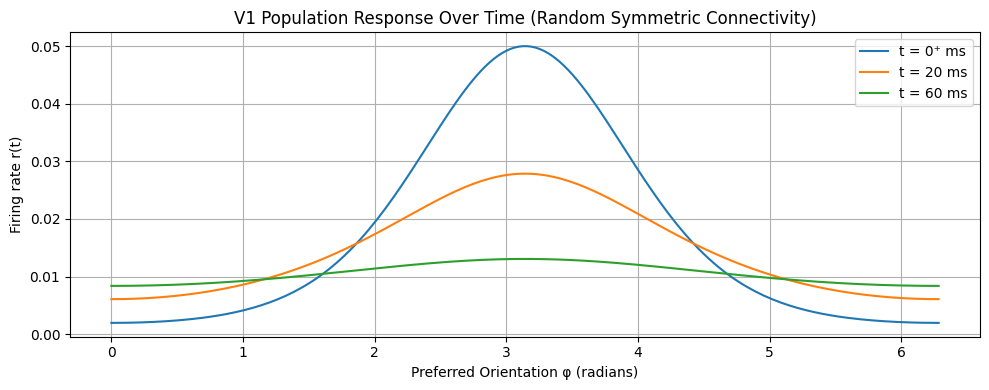

In [246]:
# Convert time steps to indices
idx_0p = 0
idx_20 = np.argmin(np.abs(time_steps - 20))
idx_60 = np.argmin(np.abs(time_steps - 60))

# Extract r(t) vectors
r_0p = r_list_w3[idx_0p]
r_20 = r_list_w3[idx_20]
r_60 = r_list_w3[idx_60]

phi = 2 * np.pi * np.linspace(0, 1, m)  # match your code

plt.figure(figsize=(10, 4))
plt.plot(phi, r_0p, label='t = 0⁺ ms')
plt.plot(phi, r_20, label='t = 20 ms')
plt.plot(phi, r_60, label='t = 60 ms')
plt.xlabel('Preferred Orientation φ (radians)')
plt.ylabel('Firing rate r(t)')
plt.title('V1 Population Response Over Time (Random Symmetric Connectivity)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Model 4: Balanced Ring Structure

In [275]:
# Model 4: Balanced Ring Structure

m = 200
n = 2*m

W_4 = np.block([
    [ W_3, -W_3],
    [ W_3, -W_3]
])                                           # (2m, 2m)

B_4 = np.vstack([np.eye(m), np.zeros((m, m))]) # (2m, m)
C_4 = np.hstack([np.eye(m), np.zeros((m, m))]) # (m, 2m)

time_steps = np.linspace(0,60,100)
theta = np.pi

# Run the simulation
r_list_w4 = run_simulation(
    theta = np.pi, 
    phi = 2 * np.pi * np.linspace(0,1,m),
    time_steps = np.linspace(0,60,100), 
    W = W_4,
    B = B_4,
    C = C_4, 
    tau = 20, 
    dt = 1, 
)

# Find the decoding error
decoding_error_w4 = decoding_error_func(
    r_list = r_list_w4, 
    C = C_4, 
    sigma = 1, 
    phi = 2 * np.pi * np.linspace(0,1,m), 
    theta = np.pi)

#### Plotting

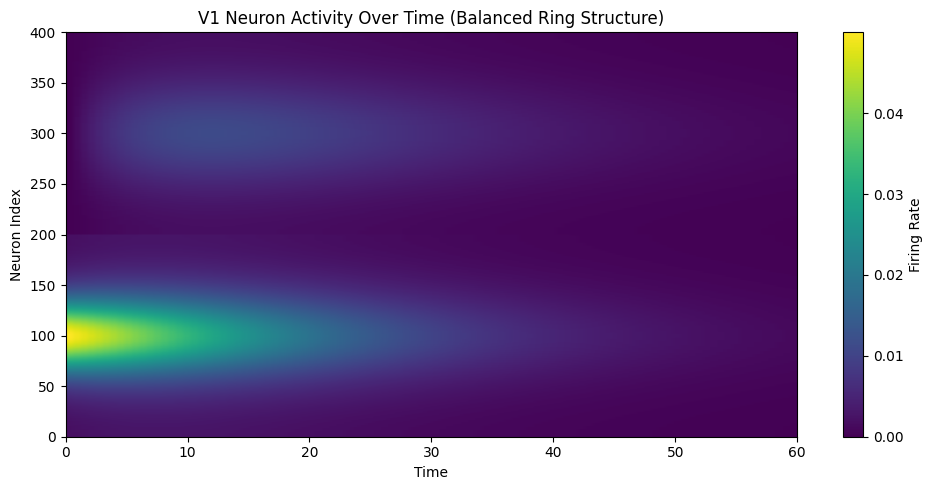

In [276]:
r_mat_w4 = np.array(r_list_w4)  # shape: (timesteps, 2m)

plt.figure(figsize=(10, 5))
plt.imshow(r_mat_w4.T, aspect='auto', cmap='viridis', origin='lower',
           extent=[time_steps[0], time_steps[-1], 0, r_mat_w4.shape[1]])
plt.colorbar(label='Firing Rate')
plt.xlabel('Time')
plt.ylabel('Neuron Index')
plt.title('V1 Neuron Activity Over Time (Balanced Ring Structure)')
plt.tight_layout()
plt.show()


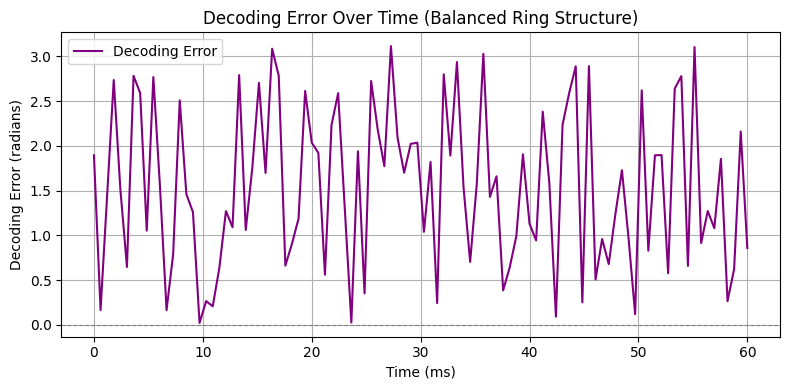

In [277]:
plt.figure(figsize=(8, 4))
plt.plot(time_steps, decoding_error_w4, label='Decoding Error', color='purple')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.xlabel('Time (ms)')
plt.ylabel('Decoding Error (radians)')
plt.title('Decoding Error Over Time (Balanced Ring Structure)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


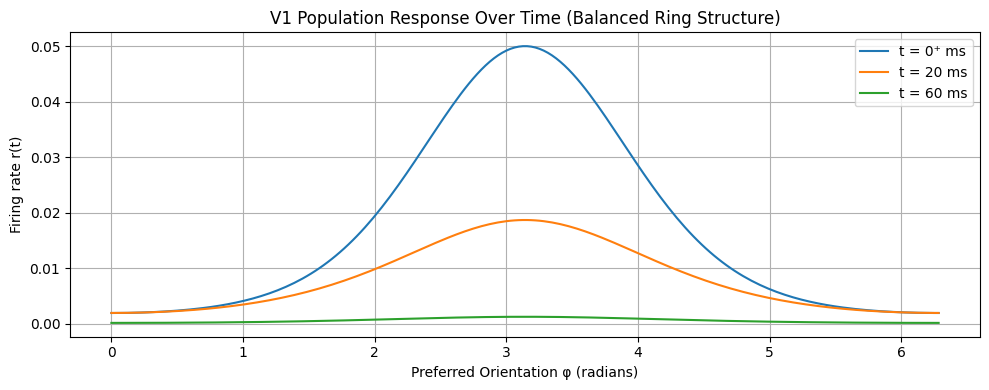

In [278]:
idx_0p = 0
idx_20 = np.argmin(np.abs(time_steps - 20))
idx_60 = np.argmin(np.abs(time_steps - 60))

# Extract first m neurons only (since C reads from them)
r_0p = r_list_w4[idx_0p][:m]
r_20 = r_list_w4[idx_20][:m]
r_60 = r_list_w4[idx_60][:m]

phi = 2 * np.pi * np.linspace(0, 1, m)

plt.figure(figsize=(10, 4))
plt.plot(phi, r_0p, label='t = 0⁺ ms')
plt.plot(phi, r_20, label='t = 20 ms')
plt.plot(phi, r_60, label='t = 60 ms')
plt.xlabel('Preferred Orientation φ (radians)')
plt.ylabel('Firing rate r(t)')
plt.title('V1 Population Response Over Time (Balanced Ring Structure)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Report Graphic

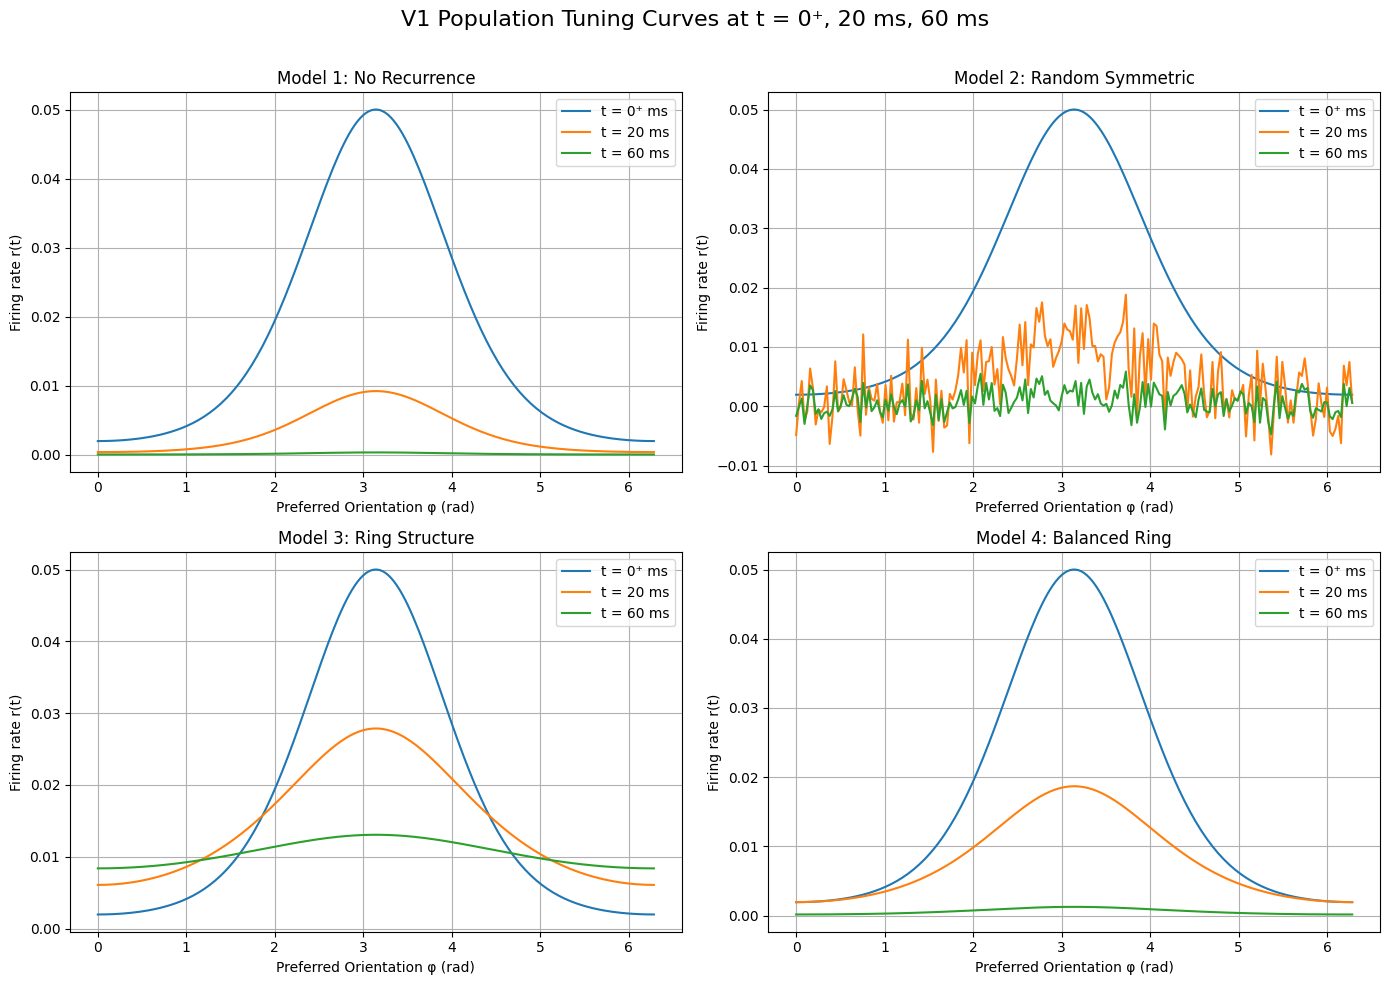

In [284]:
# Indices for t = 0⁺, 20 ms, 60 ms
idx_0p = 0
idx_20 = np.argmin(np.abs(time_steps - 20))
idx_60 = np.argmin(np.abs(time_steps - 60))

phi = 2 * np.pi * np.linspace(0, 1, m)

# Helper function to extract and plot
def plot_tuning(ax, r_list, label):
    r_0p = r_list[idx_0p][:m]
    r_20 = r_list[idx_20][:m]
    r_60 = r_list[idx_60][:m]
    
    ax.plot(phi, r_0p, label='t = 0⁺ ms')
    ax.plot(phi, r_20, label='t = 20 ms')
    ax.plot(phi, r_60, label='t = 60 ms')
    ax.set_title(label)
    ax.set_xlabel('Preferred Orientation φ (rad)')
    ax.set_ylabel('Firing rate r(t)')
    ax.grid(True)

# Plot all four
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
plot_tuning(axs[0, 0], r_list_w1, 'Model 1: No Recurrence')
plot_tuning(axs[0, 1], r_list_w2, 'Model 2: Random Symmetric')
plot_tuning(axs[1, 0], r_list_w3, 'Model 3: Ring Structure')
plot_tuning(axs[1, 1], r_list_w4, 'Model 4: Balanced Ring')

# Tidy up
for ax in axs.flatten():
    ax.legend()

plt.suptitle('V1 Population Tuning Curves at t = 0⁺, 20 ms, 60 ms', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


### Question 2: Investigations into Model 2

We begin by investigating the variance against time for all 4 fitted models, presuming that at each discretised time step we can fit a Gaussian. We then measure the "noise" as the difference between the actual activity and the fitted Gaussian: the residual. We then compute the standard deviation of the residuals for each model over time - thus capturing irregularities and small-scale noise.

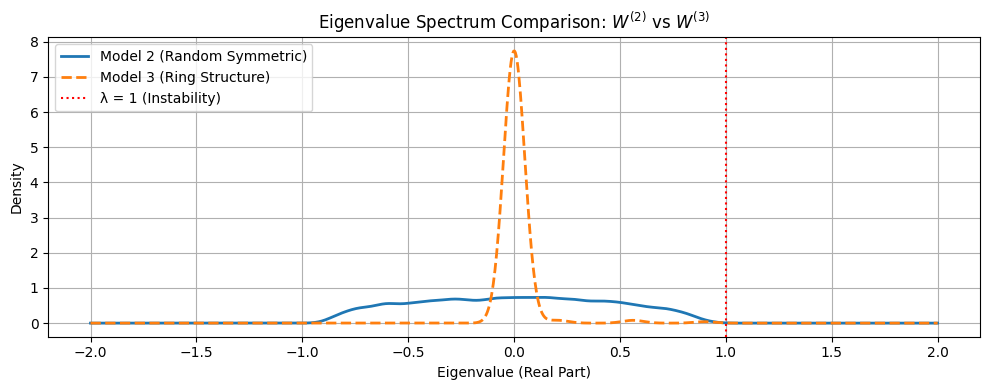

In [295]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Get real parts of eigenvalues
eigvals_w2 = np.linalg.eigvals(W_2).real
eigvals_w3 = np.linalg.eigvals(W_3).real

# Create x-axis range for KDE
x = np.linspace(-2, 2, 1000)

# KDE function
def kde_curve(eigvals, bandwidth=0.05):
    density = np.zeros_like(x)
    for val in eigvals:
        density += norm.pdf(x, loc=val, scale=bandwidth)
    return density / len(eigvals)

# Compute KDEs
density_w2 = kde_curve(eigvals_w2)
density_w3 = kde_curve(eigvals_w3)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(x, density_w2, label='Model 2 (Random Symmetric)', linewidth=2)
plt.plot(x, density_w3, label='Model 3 (Ring Structure)', linestyle='--', linewidth=2)

plt.axvline(1, color='red', linestyle=':', label='λ = 1 (Instability)')
plt.xlabel('Eigenvalue (Real Part)')
plt.ylabel('Density')
plt.title('Eigenvalue Spectrum Comparison: $W^{(2)}$ vs $W^{(3)}$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Question 3: Investigation into Model 3

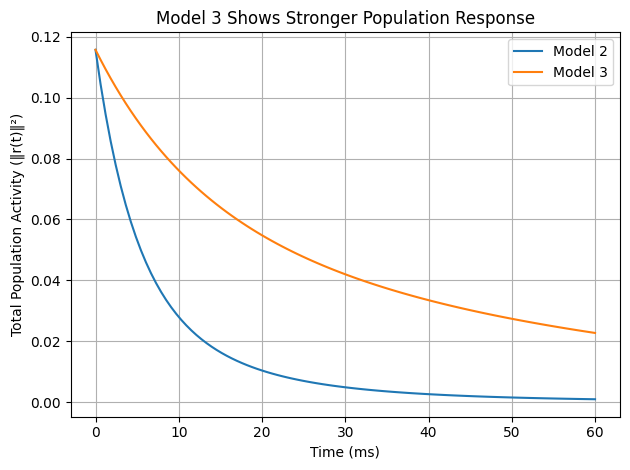

In [297]:
def total_response(r_list):
    return [np.linalg.norm(r)**2 for r in r_list]

resp_2 = total_response(r_list_w2)
resp_3 = total_response(r_list_w3)

plt.plot(time_steps, resp_2, label='Model 2')
plt.plot(time_steps, resp_3, label='Model 3')
plt.xlabel("Time (ms)")
plt.ylabel("Total Population Activity (‖r(t)‖²)")
plt.title("Model 3 Shows Stronger Population Response")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Question 4


In [149]:
# Euler Method Update Function - this is an el classico
def update_r(r_t, t, W, B, h_theta, tau, dt):
    # Dirac delta pulse at t=0
    input_term = B @ h_theta if t == 0 else 0
    
    # Correct update equation
    dr_dt = (1/tau) * (-r_t + W @ r_t + input_term)
    r = r_t + dt * dr_dt
    return r

In [150]:
import random 

def run_simulation_rand(theta, phi, time_steps, W, B, C, tau, dt, random_seed):

    random.seed(random_seed)

    # --- Main simulation ---

    # Vector: V(phi-theta), where phi is the grid of regularly spaced points, and theta is the input orientation
    # The V function is a Von-Mises distribution, commonly used to model data measured on a circle (e.g. orientation)
    h_model = h(phi, theta)

    # Vector: the ith element of this vector represents the momentary firing rate of V1 neuron i 
    r_list = [np.zeros(W.shape[0])] # added a dummy value at the start so by code doesn't f*ck up 

    # for each time step
    for i, time in enumerate(time_steps):

        # r = update r given the previous one
        r = update_r(r_list[i], time, W, B, h_model, tau, dt)

        r_list.append(r) # appending r to my list

    r_list = r_list[1:] # getting rid of dummy value - is this optimal coding 😳
    
    return r_list


In [151]:
def decoding_error_func(r_list, C, sigma, phi, theta):

    decoding_error_list = []

    for r in r_list: # r is a vector size n!

        noise = np.random.normal(0,1, size = C.shape[0])

        o_tilde = (C @ r) + (sigma * noise)

        x = np.sum(o_tilde * np.sin(phi))
        y = np.sum(o_tilde * np.cos(phi))
        
        theta_hat =  np.arctan2(x,y)

        decoding_error = np.arccos(np.cos(theta_hat-theta))

        decoding_error_list.append(decoding_error)

    return decoding_error_list


In [165]:
tau = 0.02 # characteristic neuron time constant (in m)

m = 200 # number of regularly spaced orientations

n = 200 # number of neuronal inputs

B = np.eye(m,m) # feedforward input weights

C = np.eye(m,m) # matrix of output weights

sigma = 1 # noise of readout activity 

k = np.pi/4 # encoder constant

alpha = 0.9 # recurrent connection strength constant 1

alpha_prime = 0.9 # recurrent connection strength constant 2

phi = 2 * np.pi * np.linspace(0,1,m) # grid of regularly spaced parameters

dt = 0.001 # timestep (in s)


#### Model 1

In [187]:
theta = np.pi
n_trials = 100
time_steps = np.linspace(0, 0.06, num=60)
W_1 = np.zeros((m,m))

decoding_errors_w1 = []

for trial in range(n_trials):

    r_list = run_simulation_rand(theta, phi, time_steps, W_1, B, C, tau, dt, random_seed=trial)
    err = decoding_error_func(r_list, C, sigma, phi, theta)
    decoding_errors_w1.append(err)

# Average over trials
avg_error_w1 = np.mean(decoding_errors_w1, axis=0)



#### Model 2

In [188]:
W_tilde = np.random.normal(0, 1, size=B.shape)
W_2 = R(W_tilde + W_tilde.T, alpha)

In [189]:
decoding_errors_w2 = []
for trial in range(n_trials):
    r_list = run_simulation_rand(theta, phi, time_steps, W_2, B, C, tau, dt, random_seed=trial)
    err = decoding_error_func(r_list, C, sigma, phi, theta)
    decoding_errors_w2.append(err)

# Average over trials
avg_error_w2 = np.mean(decoding_errors_w2, axis=0)

#### Model 3

In [190]:
W_ij = np.zeros_like(B)
for i in range(m):
    for j in range(m):
        W_ij[i,j] = V(phi[i]-phi[j])

W_3 = R(W_ij, alpha)

decoding_errors_w3 = []
for trial in range(n_trials):
    r_list = run_simulation_rand(theta, phi, time_steps, W_3, B, C, tau, dt, random_seed=trial)
    err = decoding_error_func(r_list, C, sigma, phi, theta)
    decoding_errors_w3.append(err)

# Average over trials
avg_error_w3 = np.mean(decoding_errors_w3, axis=0)

#### Model 4

In [191]:
m = 200
n = 2*m

W_4 = np.block([
    [ W_3, -W_3],
    [ W_3, -W_3]
])                                           # (2m, 2m)

B_4 = np.vstack([np.eye(m), np.zeros((m, m))]) # (2m, m)
C_4 = np.hstack([np.eye(m), np.zeros((m, m))]) # (m, 2m)

decoding_errors_w4 = []
for trial in range(n_trials):
    r_list = run_simulation_rand(theta, phi, time_steps, W_4, B_4, C_4, tau, dt, random_seed=trial)
    err = decoding_error_func(r_list, C_4, sigma, phi, theta)
    decoding_errors_w4.append(err)

# Average over trials
avg_error_w4 = np.mean(decoding_errors_w4, axis = 0)

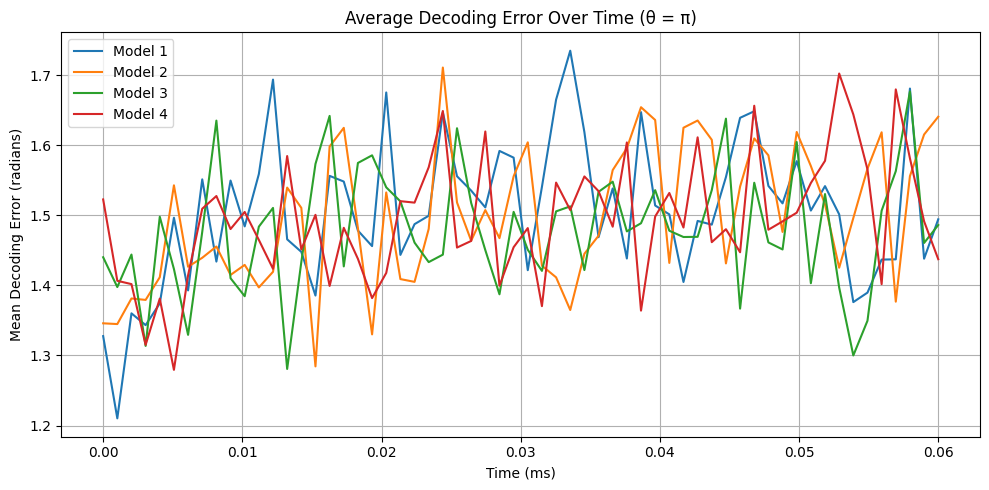

In [193]:
plt.figure(figsize=(10, 5))
plt.plot(time_steps, avg_error_w1, label='Model 1')
plt.plot(time_steps, avg_error_w2, label='Model 2')
plt.plot(time_steps, avg_error_w3, label='Model 3')
plt.plot(time_steps, avg_error_w4, label='Model 4')
plt.xlabel("Time (ms)")
plt.ylabel("Mean Decoding Error (radians)")
plt.title("Average Decoding Error Over Time (θ = π)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [196]:
import numpy as np
from scipy import linalg

# --- Parameters ---
m = 200
phi = np.linspace(0, 2 * np.pi, m, endpoint=False)
alpha = 0.9
alpha_prime = 0.9
kappa = np.pi / 4

# --- Tuning function ---
def V(z, kappa=kappa):
    return np.exp((np.cos(z) - 1) / (kappa**2))

# --- Rescale W to have spectral abscissa α ---
def rescale_matrix(W, target_alpha):
    if np.all(W == 0):
        return W
    eigvals = linalg.eigvals(W)
    max_real = np.max(np.real(eigvals))
    return W * (target_alpha / max_real) if max_real != 0 else W


In [197]:
W1 = np.zeros((m, m))

W_tilde = np.random.normal(0, 1, (m, m))
W2 = rescale_matrix(W_tilde + W_tilde.T, alpha)

W3 = np.zeros((m, m))
for i in range(m):
    for j in range(m):
        W3[i, j] = V(phi[i] - phi[j])
W3 = rescale_matrix(W3, alpha)

W_ring = np.zeros((m, m))
for i in range(m):
    for j in range(m):
        W_ring[i, j] = V(phi[i] - phi[j])
W_ring = rescale_matrix(W_ring, alpha_prime)

n_model = 2 * m  # Double the neurons

W4 = np.zeros((n_model, n_model))
W4[:m, :m] = W_ring         # E→E
W4[:m, m:] = -W_ring        # I→E (inhibitory input)
W4[m:, :m] = W_ring         # E→I
W4[m:, m:] = -W_ring        # I→I (self-inhibition)





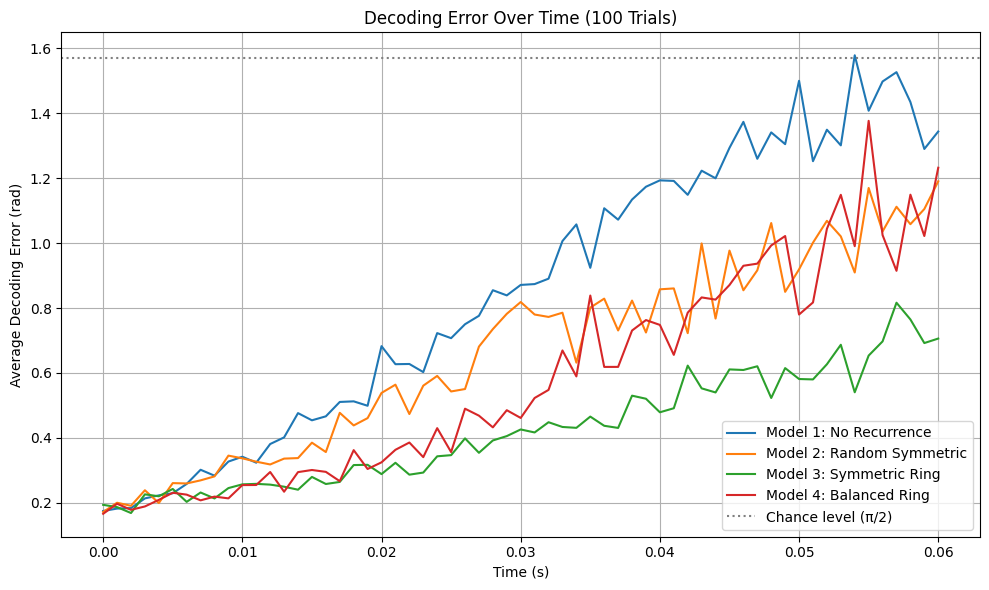

In [200]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

# --- Parameters ---
m = 200
tau = 0.02
dt = 0.001
kappa = np.pi / 4
alpha = 0.9
sigma = 1
theta = np.pi
duration = 0.06
num_time_steps = int(duration / dt) + 1
phi = np.linspace(0, 2 * np.pi, m, endpoint=False)

# --- Von Mises tuning + stimulus encoding ---
def stimulus_encoding(phi_i, theta, kappa=kappa):
    return np.exp((np.cos(phi_i - theta) - 1) / (kappa**2))

def h_theta_vector(phi, theta):
    return stimulus_encoding(phi, theta)

# --- Rescale matrix by spectral abscissa ---
def rescale_matrix(W, target_alpha):
    if np.all(W == 0):
        return W
    eigvals = linalg.eigvals(W)
    max_real = np.max(np.real(eigvals))
    return W * (target_alpha / max_real) if max_real != 0 else W

def network_model(model_num, m, phi, alpha, alpha_prime):
    def V(z, kappa=np.pi/4):
        return np.exp((np.cos(z) - 1) / kappa**2)

    def rescale_matrix(W, target_alpha):
        if np.all(W == 0):
            return W
        eigvals = linalg.eigvals(W)
        max_real = np.max(np.real(eigvals))
        return W * (target_alpha / max_real) if max_real != 0 else W

    if model_num == 1:
        # Model 1: No recurrence
        W = np.zeros((m, m))
        B = np.eye(m)
        C = np.eye(m)
        n_model = m

    elif model_num == 2:
        # Model 2: Random symmetric
        W_tilde = np.random.normal(0, 1, (m, m))
        W = rescale_matrix(W_tilde + W_tilde.T, alpha)
        B = np.eye(m)
        C = np.eye(m)
        n_model = m

    elif model_num == 3:
        # Model 3: Symmetric ring structure
        W = np.zeros((m, m))
        for i in range(m):
            for j in range(m):
                W[i, j] = V(phi[i] - phi[j])
        W = rescale_matrix(W, alpha)
        B = np.eye(m)
        C = np.eye(m)
        n_model = m

    elif model_num == 4:
        # Model 4: Balanced ring structure (E/I split)
        W_ring = np.zeros((m, m))
        for i in range(m):
            for j in range(m):
                W_ring[i, j] = V(phi[i] - phi[j])
        W_ring = rescale_matrix(W_ring, alpha_prime)

        n_model = 2 * m
        W = np.zeros((n_model, n_model))
        W[:m, :m] = W_ring       # E→E
        W[:m, m:] = -W_ring      # I→E
        W[m:, :m] = W_ring       # E→I
        W[m:, m:] = -W_ring      # I→I

        B = np.zeros((n_model, m))
        B[:m, :] = np.eye(m)

        C = np.zeros((m, n_model))
        C[:, :m] = np.eye(m)

    else:
        raise ValueError(f"Model {model_num} is not implemented (must be 1–4).")

    return W, B, C, n_model


# --- Simulation ---
def simulate_model(W, B, C, h_theta, tau, dt, num_time_steps):
    n_model = W.shape[0]
    r = np.zeros((n_model, num_time_steps))
    r[:, 0] = B @ h_theta
    for i in range(1, num_time_steps):
        dr = (-r[:, i-1] + W @ r[:, i-1]) * (dt / tau)
        r[:, i] = r[:, i-1] + dr
    return r

# --- Decode θ̂(t) and compute circular distance error ---
def compute_decoding_error(r, C, sigma, phi, theta, num_trials=100):
    m, T = C.shape[0], r.shape[1]
    all_errors = []
    for _ in range(num_trials):
        trial_errors = []
        for t in range(T):
            noise = sigma * np.random.randn(m)
            o_tilde = C @ r[:, t] + noise
            x = np.sum(o_tilde * np.cos(phi))
            y = np.sum(o_tilde * np.sin(phi))
            theta_hat = np.arctan2(y, x) % (2 * np.pi)
            error = np.abs(np.angle(np.exp(1j * (theta_hat - theta))))
            trial_errors.append(error)
        all_errors.append(trial_errors)
    return np.mean(all_errors, axis=0)

# --- Run everything for Model 1 and Model 2 ---
time_axis = np.linspace(0, duration, num_time_steps)
h_theta = h_theta_vector(phi, theta)

# --- Run everything for Models 1 to 4 ---
time_axis = np.linspace(0, duration, num_time_steps)
h_theta = h_theta_vector(phi, theta)

# Model 1
W1, B1, C1, _ = network_model(1, m, phi, alpha,alpha_prime)
r1 = simulate_model(W1, B1, C1, h_theta, tau, dt, num_time_steps)
error1 = compute_decoding_error(r1, C1, sigma, phi, theta, num_trials=100)

# Model 2
W2, B2, C2, _ = network_model(2, m, phi, alpha,alpha_prime)
r2 = simulate_model(W2, B2, C2, h_theta, tau, dt, num_time_steps)
error2 = compute_decoding_error(r2, C2, sigma, phi, theta, num_trials=100)

# Model 3
W3, B3, C3, _ = network_model(3, m, phi, alpha,alpha_prime)
r3 = simulate_model(W3, B3, C3, h_theta, tau, dt, num_time_steps)
error3 = compute_decoding_error(r3, C3, sigma, phi, theta, num_trials=100)

# Model 4
W4, B4, C4, _ = network_model(4, m, phi, alpha, alpha_prime)
r4 = simulate_model(W4, B4, C4, h_theta, tau, dt, num_time_steps)
error4 = compute_decoding_error(r4, C4, sigma, phi, theta, num_trials=100)

# --- Plot results ---
plt.figure(figsize=(10, 6))
plt.plot(time_axis, error1, label='Model 1: No Recurrence')
plt.plot(time_axis, error2, label='Model 2: Random Symmetric')
plt.plot(time_axis, error3, label='Model 3: Symmetric Ring')
plt.plot(time_axis, error4, label='Model 4: Balanced Ring')
plt.axhline(np.pi / 2, color='gray', linestyle=':', label='Chance level (π/2)')
plt.xlabel("Time (s)")
plt.ylabel("Average Decoding Error (rad)")
plt.title("Decoding Error Over Time (100 Trials)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

